# Image Augmentation for Deep Learning

* Generate augmented images using ImageDataGenerator in Keras
* Generate custom augmented images using Contrast Stretching, Histogram Equalization, Adaptive Histogram Equalization
* Use image augmentation for training convolutional neural network on CIFAR-10 dataset

In [7]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize

import keras
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# Experimenting with ImageDataGenerator

In [12]:
# define function to generate images

def imgGen(img, zca=False, rotation=0., w_shift=0., h_shift=0., shear=0., zoom=0., h_flip=False, v_flip=False,  preprocess_fcn=None, batch_size=9):
    datagen = ImageDataGenerator(
            zca_whitening=zca,
            rotation_range=rotation,
            width_shift_range=w_shift,
            height_shift_range=h_shift,
            shear_range=shear,
            zoom_range=zoom,
            fill_mode='nearest',
            horizontal_flip=h_flip,
            vertical_flip=v_flip,
            preprocessing_function=preprocess_fcn,
            data_format=K.image_data_format())
    
    datagen.fit(img)

    i=0
    for img_batch in datagen.flow(img, batch_size=9, shuffle=False):
        for img in img_batch:
            plt.subplot(330 + 1 + i)
            cv2.imwrite(f'{i}.png',img*255)
            plt.imshow(img)
            i=i+1    
        if i >= batch_size:
            break
    plt.show()

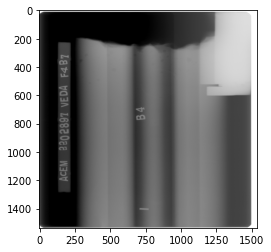

(1, 1536, 1536, 3)


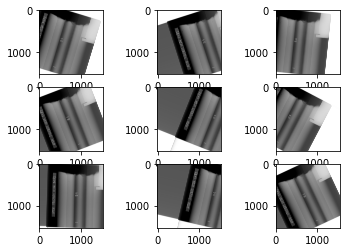

In [13]:
# visualize the image
img = imread("/Users/anishpawar/IITB/DRDO/Images/1536/2202897-VEDA-F4-B7.png")
# img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
plt.imshow(img)
plt.show()

# reshape it to prepare for data generator
img = img.astype('float32')

img /= 255
h_dim = np.shape(img)[0]
w_dim = np.shape(img)[1]
num_channel = np.shape(img)[2]
img = img.reshape(1, h_dim, w_dim, num_channel)
print(img.shape)

# generate images using function imgGen
imgGen(img, rotation=30, h_shift=0.5)

# Experimenting with contrast adjustment

In [5]:
# Define functions for contrast adjustment


# Contrast stretching
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

# Histogram equalization
def HE(img):
    img_eq = exposure.equalize_hist(img)
    return img_eq

# Adaptive histogram equalization
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

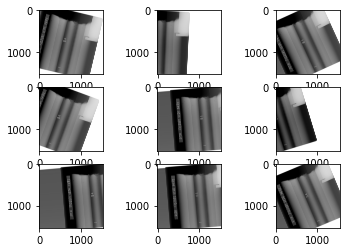

/Users/anishpawar/miniforge3/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


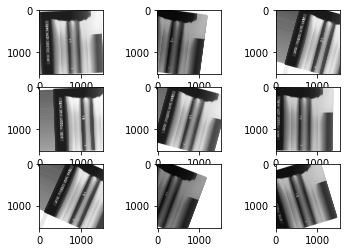

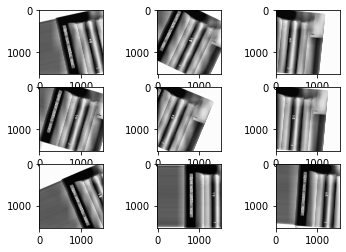

In [6]:
# generate images using function imgGen
imgGen(img, rotation=30, h_shift=0.5, preprocess_fcn = contrast_stretching)
imgGen(img, rotation=30, h_shift=0.5, preprocess_fcn = HE)
imgGen(img, rotation=30, h_shift=0.5, preprocess_fcn = AHE)

# Load and preprocess CIFAR10 image data

In [6]:
batch_size = 64
num_classes = 2
epochs = 10

# input image dimensions
img_rows, img_cols = 32, 32   

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()   
print('x_train shape:', x_train.shape)

#Only look at cats [=3] and dogs [=5]
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     

y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(np.ravel(y_train), num_classes)
y_test = keras.utils.to_categorical(np.ravel(y_test), num_classes)

x_train shape: (50000, 32, 32, 3)
x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples


# Construct CNN model

In [7]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Train model with image augmentation

In [8]:
augmentation=True

if augmentation==True:
    datagen = ImageDataGenerator(
            rotation_range=0,
            width_shift_range=0,
            height_shift_range=0,
            shear_range=0,
            zoom_range=0,
            horizontal_flip=True,
            fill_mode='nearest',
#             preprocessing_function = contrast_adjusment,
#             preprocessing_function = HE,
            preprocessing_function = AHE)

    datagen.fit(x_train)
    
    print("Running augmented training now, with augmentation")
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
else:
    print("Running regular training, no augmentation")
    history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Running augmented training now, with augmentation
Epoch 1/10


/Users/sukilau/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


156/156 [==============================] - 168s - loss: 0.6932 - acc: 0.5069 - val_loss: 0.6913 - val_acc: 0.5550

# Visualize model accuracy

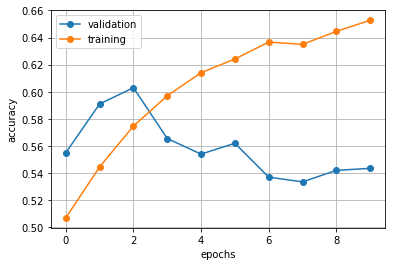

In [9]:
plt.plot(history.epoch,history.history['val_acc'],'-o',label='validation')
plt.plot(history.epoch,history.history['acc'],'-o',label='training')

plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)